In [1]:
import sys,os
__script_path=os.path.abspath(globals().get('__file__','.'))
__script_dir = os.path.dirname(__script_path)
root_dir = os.path.abspath(f'{__script_dir}/../..')
print(root_dir)
for lib in [root_dir][::-1]:
    if lib in sys.path:
        sys.path.remove(lib)
    sys.path.insert(0,lib)

from libs.lib import *

d:\ads_test


In [2]:
#Set data order
data_order = 8

In [3]:
# wandb.init(project="ads1_prj_VGG19n")


In [4]:
import tensorflow as tf
print(tf.__version__)

2.13.0


In [5]:
exps_dir = "../../../exps"
# exps_dir = sys.argv[3]

if os.path.exists(exps_dir) == False: # tạo thư mục (nếu chưa có)
  os.makedirs(exps_dir, exist_ok=True)

save_dir = f"{exps_dir}/feature1"
os.makedirs(save_dir, exist_ok=True)
test_size=0.33
seed=42

* kiểm tra và tạo các thư mục (nếu chưa có)
* tập test 33%

# 5. Xây dựng và đánh giá mô hình học sâu Neutual Network

In [6]:
dict_data=[]
y_list = []
from sklearn.preprocessing import OneHotEncoder
import numpy as np

# Dữ liệu label đã được mã hóa
def oneHot(arr):
    labels = np.array(arr)
    
    # Khởi tạo một trình chuyển đổi OneHotEncoder
    encoder = OneHotEncoder()
    
    # Reshape lại dữ liệu labels để có dạng cột (cần là ma trận 2D)
    labels_reshaped = labels.reshape(-1, 1)
    
    # Fit trình chuyển đổi vào dữ liệu
    encoder.fit(labels_reshaped)
    
    # Chuyển đổi labels sang dạng one-hot encoding
    onehot_labels = encoder.transform(labels_reshaped)
    return onehot_labels
for scaler in ['Standard_Label','MinMax_Label']:
    for type in ['basic','class_dict_weight','Oversampling','SMOTE','Undersampling']:
        x_train = pd.read_excel(f'{exps_dir}/{scaler}/{type}/feature/x_train.xlsx')
        y_train = pd.read_excel(f'{exps_dir}/{scaler}/{type}/feature/y_train.xlsx')
        x_test = pd.read_excel(f'{exps_dir}/{scaler}/{type}/feature/x_test.xlsx')
        y_test = pd.read_excel(f'{exps_dir}/{scaler}/{type}/feature/y_test.xlsx')
        y_list.append(y_test)
        y_train=oneHot(y_train)
        y_test=oneHot(y_test)
        # Tạo một tensor TensorFlow
        # data_table = tf.placeholder(shape=(None, 42), dtype=tf.float32)  # Đây là một ví dụ, bạn có thể có dữ liệu thực tế khác

        # Thêm một chiều mới vào cuối tensor
        x_train = tf.expand_dims(x_train, axis=-1)
        x_test = tf.expand_dims(x_test, axis=-1)
        print(x_train.shape,y_train.shape,x_test.shape,y_test.shape)
        dict_data.append((x_train,y_train,x_test,y_test))

class_weights_dict=dict(np.load(f'{exps_dir}/Standard_Label/class_dict_weight/feature/class_weights_dict.npz',allow_pickle=True))['class_weights_dict']
class_weights_dict = {key: value for key, value in class_weights_dict.item().items()}
class_weights_dict
print(len(dict_data))

(656, 42, 1) (656, 2) (324, 42, 1) (324, 2)
(656, 42, 1) (656, 2) (324, 42, 1) (324, 2)
(1001, 42, 1) (1001, 2) (324, 42, 1) (324, 2)
(1002, 42, 1) (1002, 2) (324, 42, 1) (324, 2)
(355, 42, 1) (355, 2) (324, 42, 1) (324, 2)
(656, 42, 1) (656, 2) (324, 42, 1) (324, 2)
(656, 42, 1) (656, 2) (324, 42, 1) (324, 2)
(1001, 42, 1) (1001, 2) (324, 42, 1) (324, 2)
(1002, 42, 1) (1002, 2) (324, 42, 1) (324, 2)
(355, 42, 1) (355, 2) (324, 42, 1) (324, 2)
10


In [7]:
x_train=pd.read_excel(f'{save_dir}/x_train.xlsx')
y_train=pd.read_excel(f'{save_dir}/y_train.xlsx')
x_test=pd.read_excel(f'{save_dir}/x_test.xlsx')
y_test=pd.read_excel(f'{save_dir}/y_test.xlsx')
class_weights_dict=dict(np.load(f'{exps_dir}/feature1/class_weights_dict.npz',allow_pickle=True))['class_weights_dict']
class_weights_dict = {key: value for key, value in class_weights_dict.item().items()}
class_weights_dict

{0: 1.0, 1: 1.0}

In [8]:
# from sklearn.preprocessing import OneHotEncoder
# import numpy as np

# # Dữ liệu label đã được mã hóa
# def oneHot(arr):
#     labels = np.array(arr)
#     # Khởi tạo một trình chuyển đổi OneHotEncoder
#     encoder = OneHotEncoder(sparse=False)
    
#     # Reshape lại dữ liệu labels để có dạng cột (cần là ma trận 2D)
#     labels_reshaped = labels.reshape(-1, 1)
    
#     # Fit trình chuyển đổi vào dữ liệu
#     encoder.fit(labels_reshaped)
    
#     # Chuyển đổi labels sang dạng one-hot encoding
#     onehot_labels = encoder.transform(labels_reshaped)
#     return onehot_labels

# y_train=oneHot(y_train)
# y_test=oneHot(y_test)

In [9]:
x_test.shape

(330, 42)

In [10]:
x_train.shape

(1022, 42)

#### * Xây dựng model:

In [11]:
#from tensorflow.keras.utils import to_categorical
#y_train = to_categorical(y_train, num_classes=2)
#y_test = to_categorical(y_test, num_classes=2)
#y_train

In [12]:
from sklearn.metrics import f1_score
import tensorflow as tf
def f1_loss(y_true, y_pred):
    true_positives = tf.reduce_sum(tf.cast(tf.logical_and(tf.equal(y_true, 1), tf.equal(y_pred, 1)), tf.float32))
    predicted_positives = tf.reduce_sum(tf.cast(y_pred, tf.float32))
    possible_positives = tf.reduce_sum(tf.cast(y_true, tf.float32))
    
    precision = true_positives / (predicted_positives + tf.keras.backend.epsilon())
    recall = true_positives / (possible_positives + tf.keras.backend.epsilon())
    
    f1 = 2 * (precision * recall) / (precision + recall + tf.keras.backend.epsilon())
    return 1 - f1

In [13]:
def focal_loss(y_true, y_pred, alpha=0.25, gamma=2.0):
    y_pred = tf.clip_by_value(y_pred, 1e-7, 1 - 1e-7)
    pt = tf.where(tf.equal(y_true, 1), y_pred, 1 - y_pred)
    loss = -tf.reduce_mean(alpha * tf.pow(1.0 - pt, gamma) * tf.math.log(pt))
    return loss


In [14]:
def dice_loss(y_true, y_pred):
    numerator = 2 * tf.reduce_sum(y_true * y_pred, axis=-1)
    denominator = tf.reduce_sum(y_true + y_pred, axis=-1)
    return 1 - (numerator + 1) / (denominator + 1)


In [15]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import backend as K

def dice_coef(y_true, y_pred, smooth):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    dice = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return dice

def dice_coef_loss(y_true, y_pred, smooth=0.0001):
    return 1 - dice_coef(y_true, y_pred, smooth)

In [16]:
from keras import backend as K

def f1_score(y_true, y_pred):
    """
    F1 score metric.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    
    f1_score = 2 * (precision * recall) / (precision + recall + K.epsilon())
    return f1_score

In [17]:
from keras.layers import Input, Conv1D, GlobalMaxPooling1D, BatchNormalization, Activation, add, MaxPooling1D, GlobalAveragePooling1D, Dense
from keras.models import Model
import keras.backend as K

def identity_block(input_tensor, kernel_size, filters, stage, block):
    """The identity block is the block that has no conv layer at shortcut."""
    filters1, filters2, filters3 = filters
    bn_axis=1
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    x = Conv1D(filters1, 1, name=conv_name_base + '2a')(input_tensor)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2a')(x)
    x = Activation('relu')(x)

    x = Conv1D(filters2, kernel_size, padding='same', name=conv_name_base + '2b')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2b')(x)
    x = Activation('relu')(x)

    x = Conv1D(filters3, 1, name=conv_name_base + '2c')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2c')(x)

    x = add([x, input_tensor])
    x = Activation('relu')(x)
    return x

def conv_block(input_tensor, kernel_size, filters, stage, block, strides=2):
    """A block that has a conv layer at shortcut."""
    filters1, filters2, filters3 = filters
    bn_axis=1
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    x = Conv1D(filters1, 1, strides=strides, name=conv_name_base + '2a')(input_tensor)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2a')(x)
    x = Activation('relu')(x)

    x = Conv1D(filters2, kernel_size, padding='same', name=conv_name_base + '2b')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2b')(x)
    x = Activation('relu')(x)

    x = Conv1D(filters3, 1, name=conv_name_base + '2c')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2c')(x)

    shortcut = Conv1D(filters3, 1, strides=strides, name=conv_name_base + '1')(input_tensor)
    shortcut = BatchNormalization(axis=bn_axis, name=bn_name_base + '1')(shortcut)

    x = add([x, shortcut])
    x = Activation('relu')(x)
    return x

In [18]:
early_stopping = EarlyStopping(monitor='val_loss',
    min_delta=0.00005,
    patience=20,
    verbose=1,
    restore_best_weights=True,
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=7,
    min_lr=0.000001,
    verbose=1,
)
checkpoint_callback = ModelCheckpoint(
    filepath='best_model.h5',  # Đường dẫn để lưu model
    monitor='val_loss',  # Theo dõi val_loss
    save_best_only=True,  # Lưu lại chỉ model có val_loss tốt nhất
    verbose=1  # Hiển thị thông báo khi lưu model
)

In [19]:
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.layers import ZeroPadding1D, Conv1D, MaxPooling1D, GlobalAveragePooling1D, Dense, Flatten, BatchNormalization, Activation, concatenate, Input
# from tensorflow.keras.models import Model
# from scikeras.wrappers import KerasClassifier 

# def build_model(filters1, filters2, filters3):
#     input_shape = (42, 1)
#     x_input = Input(shape=input_shape)

#     bn_axis = -1

#     x = ZeroPadding1D(padding=1)(x_input)
#     x = Conv1D(64, 7, strides=2, padding='same', name='conv1')(x)
#     x = BatchNormalization(axis=bn_axis, name='bn_conv1')(x)
#     x = Activation('relu')(x)
#     x = MaxPooling1D(3, strides=2)(x)

#     # ResNet blocks
#     x = conv_block(x, 3, [filters1, filters1, filters2], stage=2, block='a', strides=1)
#     block1_output = identity_block(x, 3, [filters1, filters1, filters2], stage=2, block='b')
#     x = identity_block(block1_output, 3, [filters1, filters1, filters2], stage=2, block='c')

#     x = conv_block(x, 3, [filters2, filters2, filters3], stage=3, block='a')
#     block2_output = identity_block(x, 3, [filters2, filters2, filters3], stage=3, block='b')
#     x = identity_block(block2_output, 3, [filters2, filters2, filters3], stage=3, block='c')
#     x = identity_block(x, 3, [filters2, filters2, filters3], stage=3, block='d')

   

#     # Hypercolumn formation
#     hypercolumns = concatenate([GlobalAveragePooling1D()(block1_output),
#                                 GlobalAveragePooling1D()(block2_output),
#                                 GlobalAveragePooling1D()(x)], axis=-1)

#     # Final Dense layers
#     x = Dense(128, activation='relu')(hypercolumns)
#     x = Dense(2, activation='softmax', name='fc1000')(x)

#     # Create model
#     model = Model(inputs=x_input, outputs=x, name='resnet50_1d_hypercolumn')

#     # Compile model
#     model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy',f1_score])
    
#     return model


In [20]:
import tensorflow as tf
from tensorflow import keras
from keras.activations import relu
from tensorflow.keras.layers import *
from tensorflow.keras import Model
from tensorflow.keras import layers as Layers


class ResBlock(Model):
    def __init__(self, channels, stride=1):
        super(ResBlock, self).__init__(name='ResBlock')
        self.flag = (stride != 1)
        self.conv1 = Conv1D(channels, 3, stride, padding='same')
        self.bn1 = BatchNormalization()
        self.conv2 = Conv1D(channels, 3, padding='same')
        self.bn2 = BatchNormalization()
        self.relu = ReLU()
        if self.flag:
            self.bn3 = BatchNormalization()
            self.conv3 = Conv1D(channels, 1, stride)

    def call(self, x):
        x1 = self.conv1(x)
        x1 = self.bn1(x1)
        x1 = self.relu(x1)
        x1 = self.conv2(x1)
        x1 = self.bn2(x1)
        if self.flag:
            x = self.conv3(x)
            x = self.bn3(x)
        x1 = Layers.add([x, x1])
        x1 = self.relu(x1)
        return x1


class ResNet34(Model):
    def __init__(self):
        super(ResNet34, self).__init__(name='ResNet34')
        self.conv1 = Conv1D(64, 7, 2, padding='same')
        self.bn = BatchNormalization()
        self.relu = ReLU()
        self.mp1 = MaxPooling1D(3, 2)

        self.conv2_1 = ResBlock(64)
        self.conv2_2 = ResBlock(64)
        self.conv2_3 = ResBlock(64)

        self.conv3_1 = ResBlock(128, 2)
        self.conv3_2 = ResBlock(128)
        self.conv3_3 = ResBlock(128)
        self.conv3_4 = ResBlock(128)

        self.conv4_1 = ResBlock(256, 2)
        self.conv4_2 = ResBlock(256)
        self.conv4_3 = ResBlock(256)
        self.conv4_4 = ResBlock(256)
        self.conv4_5 = ResBlock(256)
        self.conv4_6 = ResBlock(256)

        self.conv5_1 = ResBlock(512, 2)
        self.conv5_2 = ResBlock(512)
        self.conv5_3 = ResBlock(512)

        self.pool = GlobalAveragePooling1D()
        self.fc1 = Dense(2, activation='softmax')
        # self.dp1 = Dropout(0.5)
        # self.fc2 = Dense(512, activation='relu')
        # self.dp2 = Dropout(0.5)
        # self.fc3 = Dense(64)

    def call(self, x):
        x = self.conv1(x)
        x = self.bn(x)
        x = self.relu(x)
        x = self.mp1(x)

        x = self.conv2_1(x)
        x = self.conv2_2(x)
        x = self.conv2_3(x)

        x = self.conv3_1(x)
        x = self.conv3_2(x)
        x = self.conv3_3(x)
        x = self.conv3_4(x)

        x = self.conv4_1(x)
        x = self.conv4_2(x)
        x = self.conv4_3(x)
        x = self.conv4_4(x)
        x = self.conv4_5(x)
        x = self.conv4_6(x)

        x = self.conv5_1(x)
        x = self.conv5_2(x)
        x = self.conv5_3(x)

        x = self.pool(x)
        x = self.fc1(x)
        # x = self.dp1(x)
        # x = self.fc2(x)
        # x = self.dp2(x)
        # x = self.fc3(x)
        return x


model = ResNet34()
model.compile(optimizer=Adam(learning_rate=0.0001), loss=dice_coef_loss, metrics=['accuracy',f1_score])

model.build(input_shape=(None,42,1))
model.summary()

Model: "ResNet34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             multiple                  512       
                                                                 
 batch_normalization (Batch  multiple                  256       
 Normalization)                                                  
                                                                 
 re_lu (ReLU)                multiple                  0         
                                                                 
 max_pooling1d (MaxPooling1  multiple                  0         
 D)                                                              
                                                                 
 ResBlock (ResBlock)         multiple                  25216     
                                                                 
 ResBlock (ResBlock)         multiple                  252

In [21]:
model.fit(dict_data[data_order][0],dict_data[data_order][1].toarray(),
          validation_data=(dict_data[data_order][2],dict_data[data_order][3].toarray()),
          batch_size=64,epochs= 10000, callbacks=[early_stopping,lr_scheduler],class_weight={0: 0.654690618762475, 1: 5.1161290322580646})

Epoch 1/10000
16/16 [==============================] - 14s 141ms/step - loss: 1.1583 - accuracy: 0.6068 - f1_score: 0.6081 - val_loss: 0.4047 - val_accuracy: 0.7377 - val_f1_score: 0.7396 - lr: 1.0000e-04
Epoch 2/10000
16/16 [==============================] - 1s 92ms/step - loss: 0.5840 - accuracy: 0.8094 - f1_score: 0.8089 - val_loss: 0.4376 - val_accuracy: 0.5926 - val_f1_score: 0.6172 - lr: 1.0000e-04
Epoch 3/10000
16/16 [==============================] - 2s 96ms/step - loss: 0.3825 - accuracy: 0.8772 - f1_score: 0.8763 - val_loss: 0.5052 - val_accuracy: 0.4691 - val_f1_score: 0.5130 - lr: 1.0000e-04
Epoch 4/10000
16/16 [==============================] - 2s 96ms/step - loss: 0.3309 - accuracy: 0.8952 - f1_score: 0.8959 - val_loss: 0.5211 - val_accuracy: 0.4414 - val_f1_score: 0.4896 - lr: 1.0000e-04
Epoch 5/10000
16/16 [==============================] - 2s 97ms/step - loss: 0.3016 - accuracy: 0.8982 - f1_score: 0.8999 - val_loss: 0.5493 - val_accuracy: 0.3981 - val_f1_score: 0.4531 

In [22]:
# best_params = grid_result.best_params_
# print("Best parameters:", best_params)


Best parameters: {'model__filters1': 32, 'model__filters2': 96, 'model__filters3': 192, 'model__filters4': 256, 'model__filters5': 384}

Best parameters: {'model__filters1': 64, 'model__filters2': 128, 'model__filters3': 256, 'model__kernel': 3, 'model__unit': 64}


Best parameters: {'model__filters1': 64, 'model__filters2': 128, 'model__filters3': 256, 'model__learning_rate': 0.001, 'model__unit': 64}


In [23]:
# # Truy xuất mô hình tốt nhất
# best_estimator = grid_result.best_estimator_

# # Kiểm tra và truy xuất mô hình Keras từ best_estimator
# best_estimator.fit(dict_data[data_order][0],dict_data[data_order][1].toarray())
# best_estimator.build_fn(64, 128, 256).summary()

In [24]:
# resnet50=build_model(32,96,192,256,384)
# resnet50.summary()

In [25]:
# best_estimator.fit(dict_data[data_order][0],dict_data[data_order][1].toarray(),
#           validation_data=(dict_data[data_order][2],dict_data[data_order][3].toarray()),
#           batch_size=64,epochs= 10000, callbacks=[early_stopping,lr_scheduler],class_weight={0: 0.654690618762475, 1: 2.1161290322580646})

In [26]:
# history=best_estimator.history.history
# fig,axes=plt.subplots(1,2, figsize=(15,8))
# axes[0].plot(pd.DataFrame(history['val_accuracy']))
# axes[0].set_title('Training Process')

# axes[1].plot(pd.DataFrame(history['accuracy']), label='Train Accuracy')
# axes[1].plot(pd.DataFrame(history['val_accuracy']), label='Validation Accuracy')
# axes[1].plot(pd.DataFrame(history['loss']), label='Train Loss')
# axes[1].plot(pd.DataFrame(history['val_loss']), label='Validation Loss')
# axes[1].set_title('Training Process')
# axes[1].legend()

# plt.show()
# plt.savefig('train.png')

In [27]:
# resnet50.fit(dict_data[data_order][0],dict_data[data_order][1].toarray(),
#           validation_data=(dict_data[data_order][2],dict_data[data_order][3].toarray()),
#           batch_size=64,epochs= 10000, callbacks=[early_stopping,lr_scheduler,checkpoint_callback],class_weight={0: 0.654690618762475, 1: 5.1161290322580646})

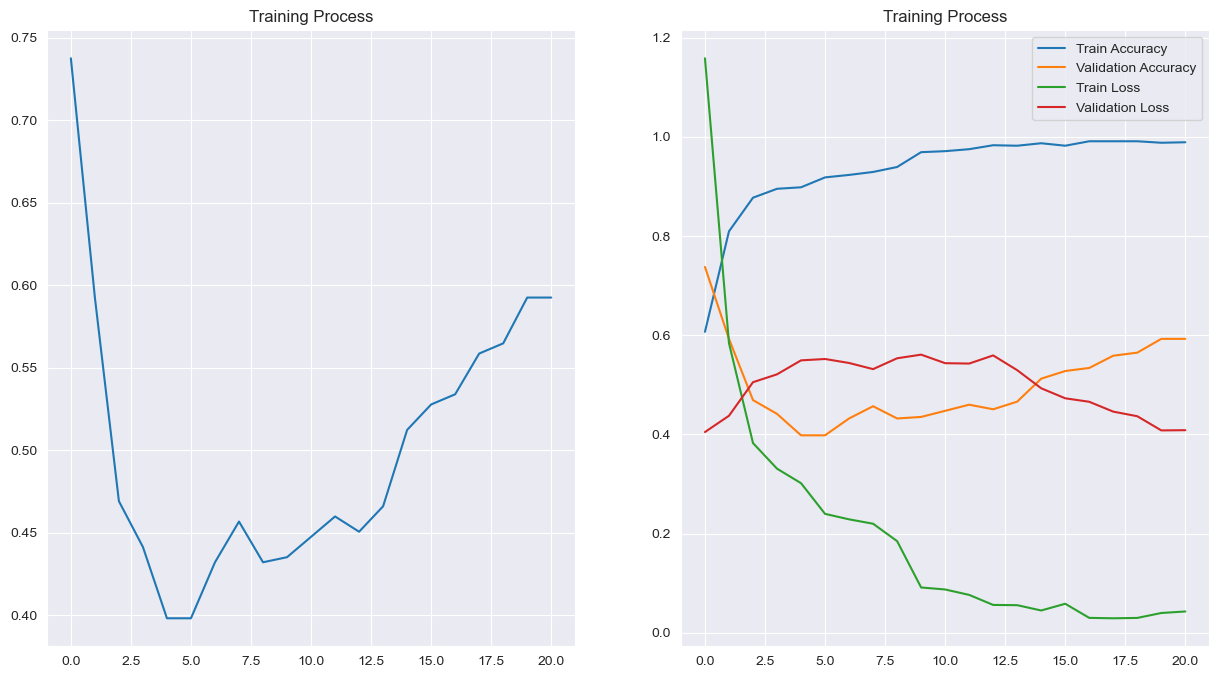

<Figure size 640x480 with 0 Axes>

In [28]:
history=model.history.history
fig,axes=plt.subplots(1,2, figsize=(15,8))
axes[0].plot(pd.DataFrame(history['val_accuracy']))
axes[0].set_title('Training Process')

axes[1].plot(pd.DataFrame(history['accuracy']), label='Train Accuracy')
axes[1].plot(pd.DataFrame(history['val_accuracy']), label='Validation Accuracy')
axes[1].plot(pd.DataFrame(history['loss']), label='Train Loss')
axes[1].plot(pd.DataFrame(history['val_loss']), label='Validation Loss')
axes[1].set_title('Training Process')
axes[1].legend()

plt.show()
plt.savefig('train.png')

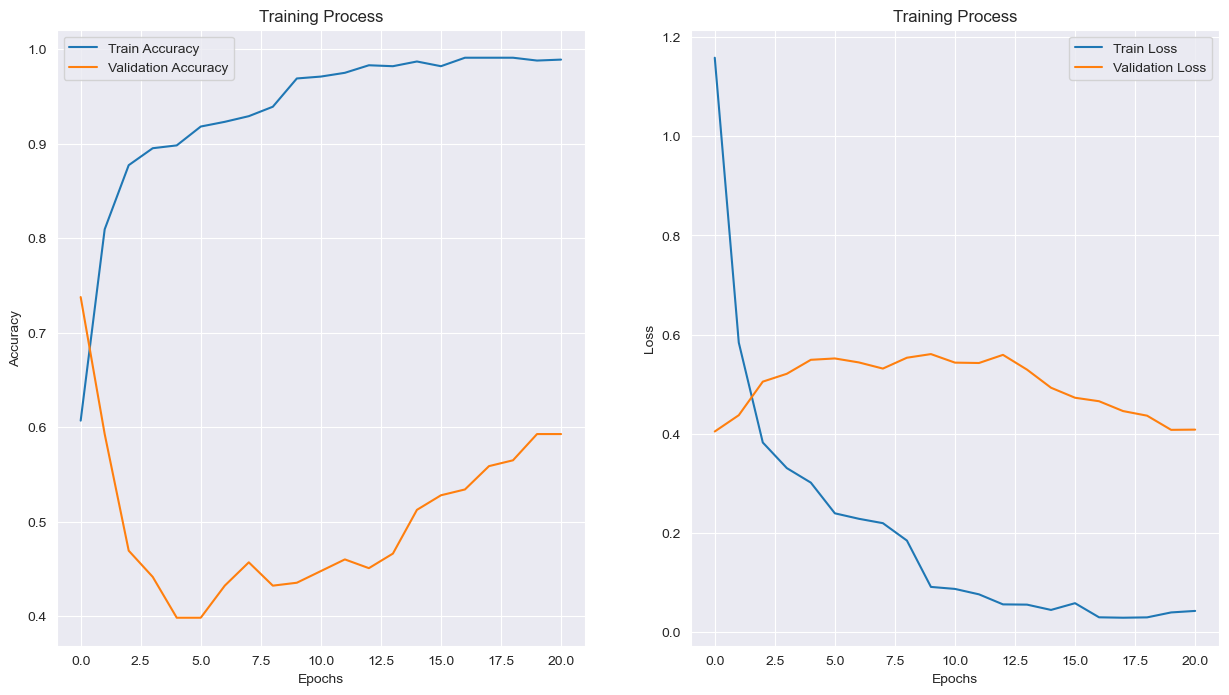

<Figure size 640x480 with 0 Axes>

In [29]:
import pandas as pd
import matplotlib.pyplot as plt

# Lấy dữ liệu từ history
history = model.history.history

# Vẽ biểu đồ
fig, axes = plt.subplots(1, 2, figsize=(15, 8))

# Biểu đồ accuracy của tập kiểm tra và tập validation
axes[0].plot(pd.DataFrame(history['accuracy']), label='Train Accuracy')
axes[0].plot(pd.DataFrame(history['val_accuracy']), label='Validation Accuracy')
axes[0].set_title('Training Process')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Accuracy')
axes[0].legend()

# Biểu đồ loss của tập kiểm tra và tập validation
axes[1].plot(pd.DataFrame(history['loss']), label='Train Loss')
axes[1].plot(pd.DataFrame(history['val_loss']), label='Validation Loss')
axes[1].set_title('Training Process')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')
axes[1].legend()

# Hiển thị biểu đồ
plt.show()

# Lưu biểu đồ vào file
plt.savefig('train.png')


In [30]:
predictions = model.predict(dict_data[data_order][2])
predictions = np.argmax(predictions, axis=1)
accuracy = accuracy_score(y_list[data_order], predictions)
accuracy

11/11 [==============================] - 1s 10ms/step


0.7376543209876543

In [31]:
x_test =dict_data[data_order][2]
y_test=y_list[data_order]

In [32]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


# Đánh giá độ chính xác
accuracy = accuracy_score(y_test, predictions)
print("Accuracy:", accuracy)

# Hiển thị báo cáo phân loại
print("Classification Report:")
print(classification_report(y_test, predictions,labels=[1,0]))

# # Hiển thị ma trận nhầm lẫn
# print("Confusion Matrix:")
# print(confusion_matrix(y_test, y_pred,labels=[1,0]))

Accuracy: 0.7376543209876543
Classification Report:
              precision    recall  f1-score   support

           1       0.50      0.06      0.11        85
           0       0.75      0.98      0.85       239

    accuracy                           0.74       324
   macro avg       0.62      0.52      0.48       324
weighted avg       0.68      0.74      0.65       324



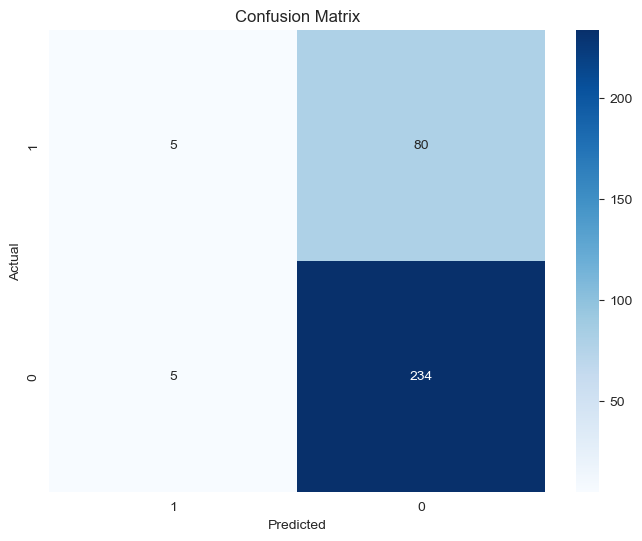

In [33]:
# Tính ma trận nhầm lẫn
cm = confusion_matrix(y_test, predictions,labels=[1,0])
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=[1,0], yticklabels=[1,0])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

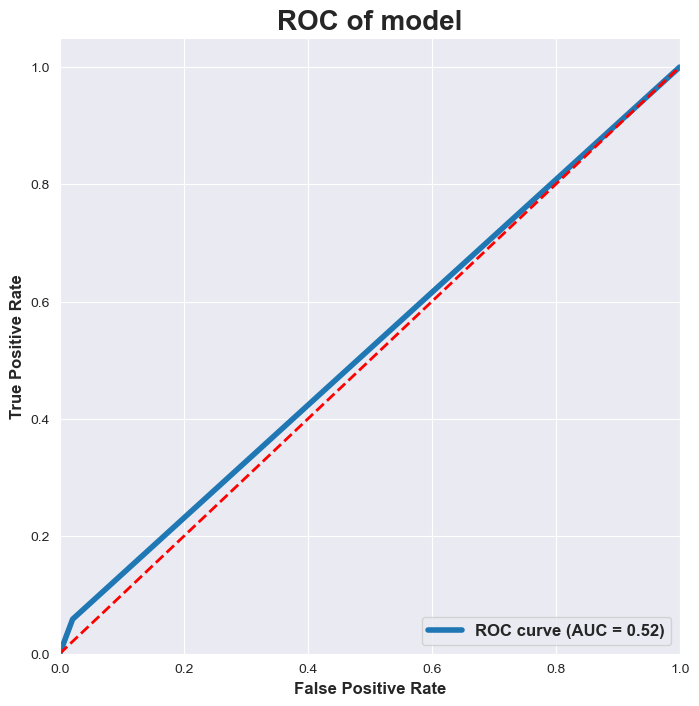

In [34]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

def plot_roc_curve(y_test, predictions,ax,name='model'):    
    # Tính toán FPR và TPR từ decision function
    fpr, tpr, _ = roc_curve(y_test, predictions)
    
    # Tính diện tích dưới đường cong ROC (AUC)
    roc_auc = auc(fpr, tpr)

    # Vẽ đường cong ROC
    ax.plot(fpr, tpr, lw=4, label='ROC curve (AUC = %0.2f)' % roc_auc)
    ax.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate', fontsize=12, weight='bold')  # Đặt kích thước và độ dày cho nhãn trục x
    ax.set_ylabel('True Positive Rate', fontsize=12, weight='bold')   # Đặt kích thước và độ dày cho nhãn trục y
    ax.set_title(f'ROC of {name}',fontsize=20, weight='bold')  # Đặt kích thước và độ dày cho tiêu đề
    ax.legend(loc="lower right", prop={'size': 12, 'weight': 'bold'})  # Đặt kích thước và độ dày cho chú thích

fig, axes = plt.subplots(1, 1, figsize=(8, 8))

plot_roc_curve(y_test,predictions,axes)
# predictions

In [35]:
def check_result(prediction):
    prediction = (prediction > 0.5).astype(int)
    if isinstance(prediction, (np.ndarray, pd.Series)):
        prediction = prediction.item()  # Hoặc sử dụng prediction[0] hoặc prediction.iloc[0]
    if prediction==1:
        return "Y"
    else:
        return "N"

In [36]:
solandung=0
hopdonggianlan=0
for indx in range(len(x_test)):
    y_predict = predictions
    #print(y_predict[0][0])
    Y_check = check_result(y_test.iloc[indx])
    print('True:', Y_check)
    print('Predicted:', check_result(y_predict[indx]))
    print("----------------------------")
    if Y_check==check_result(y_predict[indx]):
        solandung+=1
        if Y_check=='Y':
            hopdonggianlan+=1
    

True: N
Predicted: N
----------------------------
True: N
Predicted: N
----------------------------
True: N
Predicted: N
----------------------------
True: N
Predicted: N
----------------------------
True: N
Predicted: N
----------------------------
True: N
Predicted: N
----------------------------
True: N
Predicted: N
----------------------------
True: Y
Predicted: N
----------------------------
True: N
Predicted: N
----------------------------
True: N
Predicted: N
----------------------------
True: N
Predicted: N
----------------------------
True: N
Predicted: N
----------------------------
True: N
Predicted: N
----------------------------
True: Y
Predicted: N
----------------------------
True: Y
Predicted: N
----------------------------
True: N
Predicted: N
----------------------------
True: N
Predicted: N
----------------------------
True: Y
Predicted: Y
----------------------------
True: Y
Predicted: N
----------------------------
True: Y
Predicted: N
----------------------------


In [37]:
print(f"Số lần dự đoán đúng: {solandung} chiếm khoảng {(solandung/len(x_test))*100}% tổng lần dự đoán")
print(f"Số hợp đồng gian lận trong lần kiểm tra: {hopdonggianlan} chiếm khoảng {(hopdonggianlan/len(y_test[y_test['fraud_reported']==1]))*100}% so với thực tế")


Số lần dự đoán đúng: 239 chiếm khoảng 73.76543209876543% tổng lần dự đoán
Số hợp đồng gian lận trong lần kiểm tra: 5 chiếm khoảng 5.88235294117647% so với thực tế
